In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('merged_data.csv')
df = df.drop(['Unnamed: 0'], axis = 1)
df = df.drop(['Unnamed: 0.1'], axis = 1)
df.head()

,Game_date,Games_played_to_date,BA,PA,Name,ISO,SLG,BABIP,BIP,OBP,...,strike_percentage,pitches_per_appearance_avg,ground_ball_percentage,fly_ball_percentage,strikeout_percentage,next_game_team1,next_game_team2,hitter_R%,hitter_L%,next_game_hit_vs_fp
0,2014-03-31,1,0.00000,4,Travis d'Arnaud,0.0,0.00000,0.00000,0.33333,0.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0
1,2014-03-31,1,0.20000,5,Jayson Werth,0.0,0.20000,0.33333,0.60000,0.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1
2,2014-03-31,1,0.25000,5,Ian Desmond,0.0,0.25000,0.25000,1.00000,0.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1
3,2014-03-31,1,0.25000,5,Bryce Harper,0.0,0.25000,0.50000,0.50000,0.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0
4,2014-03-31,1,0.33333,5,Adam LaRoche,1.0,1.33333,0.00000,1.00000,0.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1


In [3]:
train = df[["PA","BA","pHitsByZone3", "hitter_R%", "BIP", "BABIP", "LA_median", "Weather (Degrees)", "Wind (MPH)", "Area_stand", 
            "Altitude", "H", "RUNS", "pitches_per_appearance_avg", "strikeout_percentage", "hip_last_three", 
            "ground_ball_percentage", "Strikes_Swinging", "next_game_HIT"]]

In [4]:
for i in train.columns:    
    if (train.shape[0] - train[i].count()) / train.shape[0] > .3:
        print (i)
        train = train.drop([i], axis = 1)

pHitsByZone3


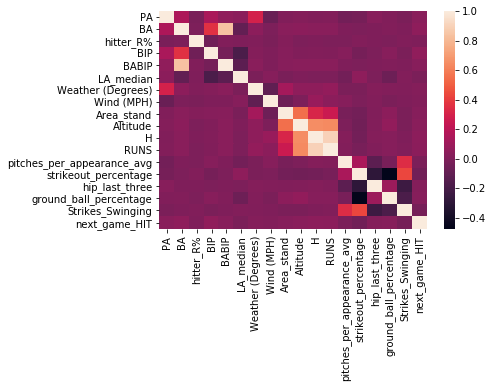

In [5]:
corr = train.corr()
sns.heatmap(corr)

In [6]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if abs(corr.iloc[i,j]) >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = train.columns[columns]
train = train[selected_columns]

In [7]:
for i in train.columns:
    if len(train[i].unique()) > 2:
        train[i] = train[i].fillna(train[i].median())
    else:
        train[i] = train[i].fillna(train[i].mode()[0])

In [8]:
def balance_hits(df_cleaned, target):
    num_samples = min(df_cleaned[target].value_counts()[0],df_cleaned[target].value_counts()[1])
    hits_indices = df_cleaned[df_cleaned[target]==1].index
    non_hits_indices =df_cleaned[df_cleaned[target]==0].index

    if (len(hits_indices) > len(non_hits_indices)):
        random_indices = np.random.choice(hits_indices, num_samples, replace = False)
        all_indices_to_keep = sorted(list(random_indices)+ list(non_hits_indices))
        cleaned_again = df_cleaned.loc[all_indices_to_keep].reset_index(drop=True)
    else:
        random_indices = np.random.choice(non_hits_indices, num_samples, replace = False)
        all_indices_to_keep = sorted(list(random_indices)+ list(hits_indices))
        cleaned_again = df_cleaned.loc[all_indices_to_keep].reset_index(drop=True)

    return cleaned_again

In [9]:
train = balance_hits(train, 'next_game_HIT')
test = train['next_game_HIT']
train = train.drop('next_game_HIT', axis = 1)

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(train, test, test_size = 0.20, shuffle = False)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score

clf = LogisticRegression(solver = 'sag', max_iter = 3000)
clf.fit(X_train, y_train.values.ravel())
predictions = clf.predict(X_test)
print (precision_score(y_test, predictions))
scores = cross_val_score(clf, X_train, y_train.values.ravel(), cv=10)
print (scores)

0.530551637092583
[0.54829259 0.53977845 0.55991944 0.5360249  0.5413348  0.54398975
 0.51405292 0.54106015 0.53497528 0.54101813]


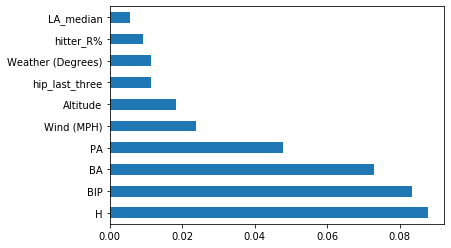

In [12]:
feat_importances = pd.Series(clf.coef_[0], index=train.columns)
feat_importances.nlargest(10).plot(kind = 'barh')

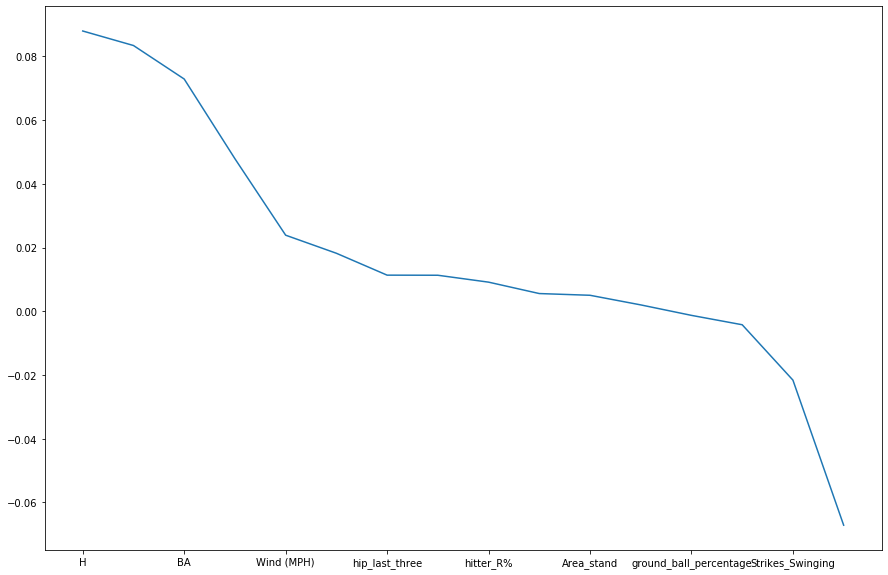

In [13]:
feat_importances.nlargest(len(feat_importances)).plot(kind = 'line', figsize = (15, 10))

In [14]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score

clf = SGDClassifier(loss="log", max_iter = 3000)
clf.fit(X_train, y_train.values.ravel())
predictions = clf.predict(X_test)
print (precision_score(y_test, predictions))
scores = cross_val_score(clf, X_train, y_train.values.ravel(), cv=10)
print (scores)

0.5233171127331712
[0.48869358 0.52632061 0.52970796 0.5329122  0.51963746 0.52348256
 0.51588391 0.51469377 0.51931881 0.53415125]


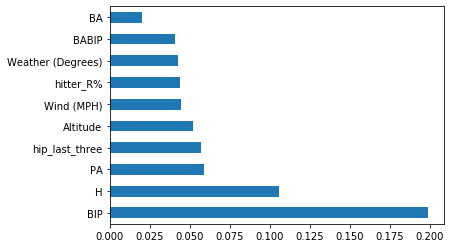

In [15]:
feat_importances = pd.Series(clf.coef_[0], index=train.columns)
feat_importances.nlargest(10).plot(kind = 'barh')

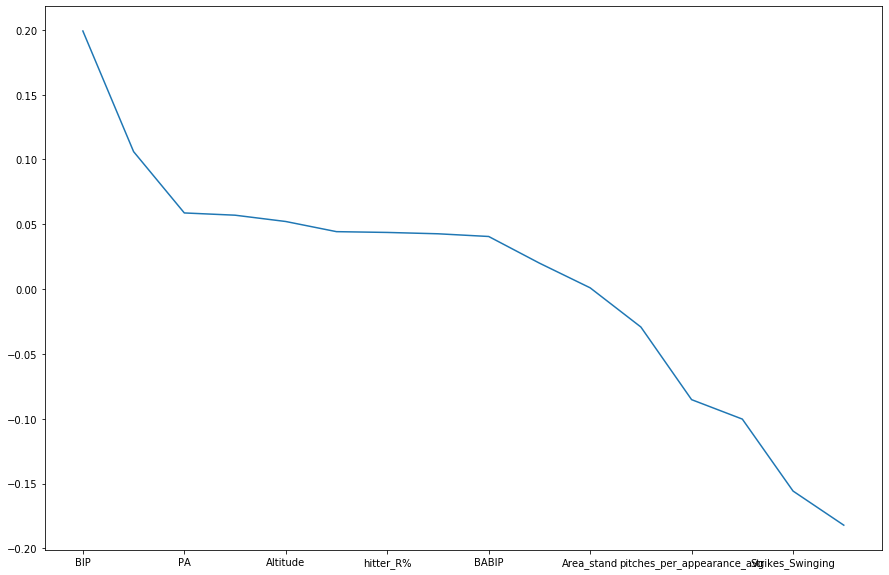

In [16]:
feat_importances.nlargest(len(feat_importances)).plot(kind = 'line', figsize = (15, 10))

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

clf = RandomForestClassifier()
clf.fit(X_train, y_train.values.ravel())
predictions = clf.predict(X_test)
print (precision_score(y_test, predictions))

0.5200182329256249


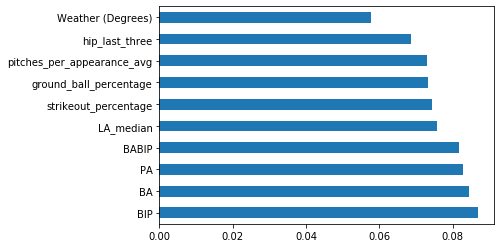

In [18]:
feat_importances = pd.Series(clf.feature_importances_, index=train.columns)
feat_importances.nlargest(10).plot(kind='barh')

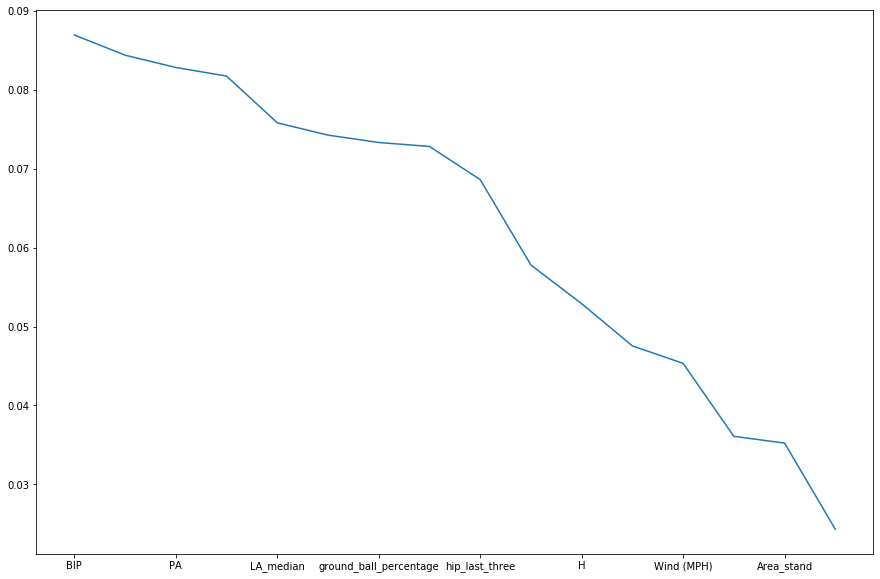

In [19]:
feat_importances.nlargest(len(feat_importances)).plot(kind='line', figsize = (15, 10))

In [20]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score

clf = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter = 3000)
clf.fit(X_train, y_train.values.ravel())
predictions = clf.predict(X_test)
print (precision_score(y_test, predictions))

0.5241088698535507


In [21]:
train = train.join(df['Name'])
train = train.join(df['next_game_HIT'])
names = train['Name'].unique().tolist()
temp = train['Name'].value_counts().to_frame()
temp = temp.reset_index()
temp.columns = ['Name', 'Count']
for i in range(len(temp)):
    if temp.at[i, 'Count'] < 30:
        names.remove(temp.at[i, 'Name'])

In [22]:
len(df['Name'].unique()) - len(names)

357

In [23]:
len(names) / len(df['Name'].unique()) 

0.6632075471698113

In [24]:
players = pd.DataFrame()

count = 0

for name in names:
    
    players.at[count, 'Name'] = name
    
    train2 = train[train['Name'] == name]
    train2 = train2.drop(['Name'], axis = 1)
    test2 = train2['next_game_HIT']
    train2 = train2.drop(['next_game_HIT'], axis = 1)
    
    players.at[count, 'Samples'] = train2.shape[0]
    
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler

    X_train, X_test, y_train, y_test = train_test_split(train2, test2, test_size = 0.20, shuffle = False)

    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import precision_score
    
    clf = LogisticRegression(solver = 'sag', max_iter = 3000)
    clf.fit(X_train, y_train.values.ravel())
    predictions = clf.predict(X_test)
    players.at[count, 'LR'] = precision_score(y_test, predictions)
    
    from sklearn.linear_model import SGDClassifier
    from sklearn.metrics import precision_score
    
    clf = SGDClassifier(loss = 'log', max_iter = 3000)
    clf.fit(X_train, y_train.values.ravel())
    predictions = clf.predict(X_test)
    players.at[count, 'SGD'] = precision_score(y_test, predictions)
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import precision_score
    
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train.values.ravel())
    predictions = clf.predict(X_test)
    players.at[count, 'RF'] = precision_score(y_test, predictions) 
    
    count += 1
               
players.head()

C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Name,Samples,LR,SGD,RF
0,Travis d'Arnaud,365.0,0.741935,0.743590,0.750000
1,Jayson Werth,376.0,0.628571,0.602941,0.619718
2,Ian Desmond,496.0,0.645161,0.602941,0.638554
3,Bryce Harper,554.0,0.642202,0.637500,0.609524
4,Adam LaRoche,193.0,0.703704,0.666667,0.703704


In [25]:
print ('LR: ' + str(players['LR'].mean()))
print ('SGD: ' + str(players['SGD'].mean()))
print ('RF: ' + str(players['RF'].mean()))

LR: 0.6129760012306521
SGD: 0.6138137365112104
RF: 0.6185960459883818


In [39]:
print ('LR Top 100: ' + str(players.sort_values(by = 'LR', ascending = False).head(100)['LR'].mean()))
print ('SGD Top 100: ' + str(players.sort_values(by = 'SGD', ascending = False).head(100)['SGD'].mean()))
print ('RF Top 100: ' + str(players.sort_values(by = 'RF', ascending = False).head(100)['RF'].mean()))

LR Top 100: 0.8298840603940211
SGD Top 100: 0.8434454915255032
RF Top 100: 0.8407150299300897


In [41]:
players.sort_values(by = 'LR', ascending = False).head()

,Name,Samples,LR,SGD,RF
662,Jose Tabata,32.0,1.0,1.0,1.000000
678,Kaleb Cowart,45.0,1.0,1.0,1.000000
598,Michael McKenry,48.0,1.0,1.0,0.888889
602,Gaby Sanchez,49.0,1.0,1.0,1.000000
607,Elian Herrera,45.0,1.0,1.0,1.000000


In [43]:
players.sort_values(by = 'SGD', ascending = False).head()

,Name,Samples,LR,SGD,RF
638,Franchy Cordero,36.0,0.833333,1.0,0.75
662,Jose Tabata,32.0,1.000000,1.0,1.00
339,Adrian Sanchez,31.0,1.000000,1.0,1.00
678,Kaleb Cowart,45.0,1.000000,1.0,1.00
652,Nick Senzel,44.0,1.000000,1.0,1.00


In [44]:
players.sort_values(by = 'RF', ascending = False).head()

,Name,Samples,LR,SGD,RF
602,Gaby Sanchez,49.0,1.0,1.0,1.0
686,Ryan LaMarre,39.0,1.0,1.0,1.0
339,Adrian Sanchez,31.0,1.0,1.0,1.0
227,Jeremy Hazelbaker,30.0,1.0,1.0,1.0
551,Josh Thole,58.0,1.0,1.0,1.0


In [51]:
len(players[players['LR'] == 1])

16

In [50]:
len(players[players['SGD'] == 1])

18

In [49]:
len(players[players['RF'] == 1])

18

In [53]:
len(players)

703